In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
churn = pd.read_csv('data/churn_ver02.csv')
churn.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Gender           10000 non-null  int64  
 2   Age              10000 non-null  int64  
 3   Tenure           10000 non-null  int64  
 4   Balance          10000 non-null  float64
 5   NumOfProducts    10000 non-null  int64  
 6   HasCrCard        10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
 9   Exited           10000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


In [4]:
churn.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [5]:
np.random.seed(123)
from sklearn.model_selection import train_test_split
target = churn.Exited
churn = churn.drop(columns='Exited')
x_train, x_test, y_train, y_test = train_test_split(churn, target, test_size=0.3, stratify=target)

### Voting

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [33]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

In [34]:
lr.fit(x_train, y_train)
knn.fit(x_train, y_train)
dt.fit(x_train, y_train)

DecisionTreeClassifier()

- Hard Voting

In [35]:
((lr.predict(x_test) + dt.predict(x_test) + knn.predict(x_test)) >= 2).astype('int')

array([0, 0, 0, ..., 0, 0, 0])

- Soft Voting

In [36]:
(lr.predict_proba(x_test)[:,1] + dt.predict_proba(x_test)[:,1] + knn.predict_proba(x_test)[:,1])/3

array([0.44321899, 0.15833298, 0.45859374, ..., 0.1611359 , 0.23933574,
       0.18081205])

In [37]:
pred = pd.DataFrame({'lr': lr.predict_proba(x_test)[:,1],
                     'dt': dt.predict_proba(x_test)[:,1], 
                     'knn':knn.predict_proba(x_test)[:,1]})
pred

,lr,dt,knn
0,0.129657,1.0,0.2
1,0.074999,0.0,0.4
2,0.375781,1.0,0.0
3,0.080015,0.0,0.0
4,0.099784,0.0,0.2
...,...,...,...
2995,0.130498,0.0,0.2
2996,0.377430,0.0,0.0
2997,0.283408,0.0,0.2
2998,0.718007,0.0,0.0


In [38]:
pred.mean(axis=1)

0       0.443219
1       0.158333
2       0.458594
3       0.026672
4       0.099928
          ...   
2995    0.110166
2996    0.125810
2997    0.161136
2998    0.239336
2999    0.180812
Length: 3000, dtype: float64

- sklearn.voting

In [39]:
from sklearn.ensemble import VotingClassifier
models = [('LR', lr),
          ('DT', dt),
          ('KNN', knn)]

hard_vot = VotingClassifier(estimators=models, voting='hard')
soft_vot = VotingClassifier(estimators=models, voting='soft')
hard_vot.fit(x_train, y_train)
soft_vot.fit(x_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('DT', DecisionTreeClassifier()),
                             ('KNN', KNeighborsClassifier())],
                 voting='soft')

- Evaluation

In [42]:
from sklearn.metrics import roc_auc_score
my_models = [lr, dt, knn, hard_vot, soft_vot]
for m in my_models:
    try:
        pred = m.predict_proba(x_test)[:,1]
    except:
        pred = m.predict(x_test)
    name = m.__class__.__name__
    score = roc_auc_score(y_test, pred)
    print('{0} ROC-AUC SCORE: {1:.4f}'.format(name, score))

LogisticRegression ROC-AUC SCORE: 0.6514
DecisionTreeClassifier ROC-AUC SCORE: 0.6843
KNeighborsClassifier ROC-AUC SCORE: 0.5348
VotingClassifier ROC-AUC SCORE: 0.5323
VotingClassifier ROC-AUC SCORE: 0.7164


### RandomForest

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [45]:
models = [('LR',lr),
          ('DT',dt),
          ('RF',rf)]
soft_vot_rf = VotingClassifier(estimators=models, voting='soft')
soft_vot_rf.fit(x_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('DT', DecisionTreeClassifier()),
                             ('RF', RandomForestClassifier(max_depth=10))],
                 voting='soft')

In [46]:
my_models = [lr, dt, knn, soft_vot, rf, soft_vot_rf]
for m in my_models:
    try:
        pred = m.predict_proba(x_test)[:,1]
    except:
        pred = m.predict(x_test)
    name = m.__class__.__name__
    score = roc_auc_score(y_test, pred)
    print('{0} ROC-AUC SCORE: {1:.4f}'.format(name, score))

LogisticRegression ROC-AUC SCORE: 0.6514
DecisionTreeClassifier ROC-AUC SCORE: 0.6843
KNeighborsClassifier ROC-AUC SCORE: 0.5348
VotingClassifier ROC-AUC SCORE: 0.7164
RandomForestClassifier ROC-AUC SCORE: 0.8568
VotingClassifier ROC-AUC SCORE: 0.8112


In [48]:
pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

Age                0.338442
NumOfProducts      0.210449
Balance            0.111499
CreditScore        0.098475
EstimatedSalary    0.091422
IsActiveMember     0.069536
Tenure             0.049001
Gender             0.020137
HasCrCard          0.011039
dtype: float64

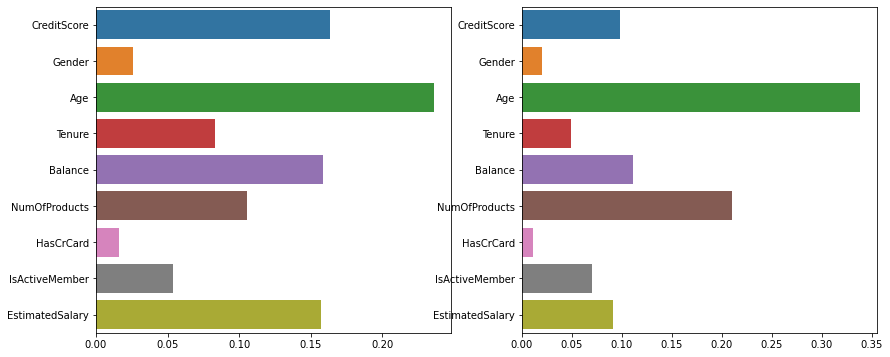

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
sns.barplot(x=dt.feature_importances_, y=x_train.columns, ax=ax[0])
sns.barplot(x=rf.feature_importances_, y=x_train.columns, ax=ax[1]);

### AdaBoosting

In [52]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=dt, learning_rate=0.3)
ada.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.3)

In [53]:
my_models = [lr, dt, knn, soft_vot, rf, soft_vot_rf, ada]
for m in my_models:
    try:
        pred = m.predict_proba(x_test)[:,1]
    except:
        pred = m.predict(x_test)
    name = m.__class__.__name__
    score = roc_auc_score(y_test, pred)
    print('{0} ROC-AUC SCORE: {1:.4f}'.format(name, score))

LogisticRegression ROC-AUC SCORE: 0.6514
DecisionTreeClassifier ROC-AUC SCORE: 0.6843
KNeighborsClassifier ROC-AUC SCORE: 0.5348
VotingClassifier ROC-AUC SCORE: 0.7164
RandomForestClassifier ROC-AUC SCORE: 0.8568
VotingClassifier ROC-AUC SCORE: 0.8112
AdaBoostClassifier ROC-AUC SCORE: 0.6759


### GradientBoosting

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
gbm.fit(x_train, y_train)

GradientBoostingClassifier()

In [56]:
my_models = [lr, dt, knn, soft_vot, rf, soft_vot_rf, ada, gbm]
for m in my_models:
    try:
        pred = m.predict_proba(x_test)[:,1]
    except:
        pred = m.predict(x_test)
    name = m.__class__.__name__
    score = roc_auc_score(y_test, pred)
    print('{0} ROC-AUC SCORE: {1:.4f}'.format(name, score))

LogisticRegression ROC-AUC SCORE: 0.6514
DecisionTreeClassifier ROC-AUC SCORE: 0.6843
KNeighborsClassifier ROC-AUC SCORE: 0.5348
VotingClassifier ROC-AUC SCORE: 0.7164
RandomForestClassifier ROC-AUC SCORE: 0.8568
VotingClassifier ROC-AUC SCORE: 0.8112
AdaBoostClassifier ROC-AUC SCORE: 0.6759
GradientBoostingClassifier ROC-AUC SCORE: 0.8622
